In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings

## Data Organization

In [2]:
big_data = pd.read_csv("trustpilot_all_data.csv")#.isna().sum()
big_data.drop(columns = ["Location Name", "Location Id"], inplace=True)
big_data.rename(columns={"Review Id":"ID_SERVICE_REVIEW"}, inplace=True)

data = pd.read_csv("service_reviews_15000rows_translated.csv")[["ID_SERVICE_REVIEW", "DS_TEXT_TRANSLATED"]]

merged_data_big = pd.merge(big_data, data, how = "right")


tagged_data = merged_data_big[["ID_SERVICE_REVIEW", "Tags", "DS_TEXT_TRANSLATED"]][merged_data_big["Tags"].isna()==False]

untagged_data = merged_data_big[["ID_SERVICE_REVIEW", "DS_TEXT_TRANSLATED"]][merged_data_big["Tags"].isna()==True]

cat_map = {
    'costumerservice': "Customer Service",
    'delivery-service': "Delivery Service",
    'delivery-service,costumerservice': "Mixed",
    'delivery-service,product-quality': "Mixed",
    'delivery-service,web-review,product-quality': "Mixed",
    'devolucion': "Customer Service",
    'devolucion,product-quality': "Mixed",
    'product-quality': "Product Quality",
    'product-quality,delivery-service': "Mixed",
    'product-quality,web-review': "Product Quality",
    'producto': "Product Quality",
    'serviciopost-venta': "Customer Service",
    'servicioposventa': "Customer Service",
    'servicioposventa,delivery-service': "Mixed",
    'web-review': "Other",
    'costumerservice,': "Customer Service",
    'costumerservice,delivery-service': "Mixed",
    'costumerservice,delivery-service,': "Mixed",
    'costumerservice,delivery-service,product-quality': "Mixed",
    'costumerservice,devolucion': "Customer Service",
    'costumerservice,devolucion,': "Customer Service",
    'costumerservice,product-quality': "Mixed",
    'costumerservice,product-quality,delivery-service': "Mixed",
    'costumerservice,product-quality,serviciopost-venta': "Mixed",
    'costumerservice,producto': "Mixed",
    'costumerservice,producto,': "Mixed",
    'costumerservice,producto,serviciopost-venta': "Mixed",
    'costumerservice,producto,serviciopost-venta,': "Mixed",
    'costumerservice,serviciopost-venta': "Customer Service",
    'delivery-service,costumerservice,product-quality': "Mixed",
    'delivery-service,devolucion': "Delivery Service",
    'delivery-service,p,product-quality': "Mixed",
    'delivery-service,product-quality,costumerservice': "Mixed",
    'delivery-service,product-quality,devolucion': "Mixed",
    'delivery-service,product-quality,serviciopost-venta': "Mixed",
    'delivery-service,product-quality,servicioposventa': "Mixed",
    'delivery-service,product-quality,web-review': "Mixed",
    'delivery-service,producto': "Mixed",
    'delivery-service,serviciopost-venta': "Mixed",
    'delivery-service,serviciopost-venta,product-quality': "Mixed",
    'delivery-service,servicioposventa': "Mixed",
    'delivery-service,web-review': "Delivery Service",
    'devolucion,': "Customer Service",
    'devolucion,costumerservice': "Customer Service",
    'devolucion,producto': "Mixed",
    'devolucion,serviciopost-venta': "Customer Service",
    'manual-send': "Other",
    'manual-send,servicioposventa': "Customer Service",
    'product-quality,': "Product Quality",
    'product-quality,costumerservice': "Mixed",
    'product-quality,delivery-service,web-review':"Mixed",
    'product-quality,devolucion': "Mixed",
    'product-quality,serviciopost-venta': "Mixed",
    'product-quality,servicioposventa': "Mixed",
    'product-quality,web-review,delivery-service': "Mixed",
    'product-quality,web-review,servicioposventa': "Mixed",
    'producto,costumerservice': "Mixed",
    'producto,delivery-service': "Mixed",
    'producto,product-quality': "Product Quality",
    'producto,serviciopost-venta': "Mixed",
    'serviciopost-venta,': "Customer Service",
    'serviciopost-venta,delivery-service': "Mixed",
    'serviciopost-venta,product-quality': "Mixed",
    'serviciopost-venta,spam': "Other",
    'servicioposventa,product-quality': "Mixed",
    'spam': "Other",
    'web-review,delivery-service': "Delivery Service",
    'web-review,delivery-service,product-quality': "Mixed",
    'web-review,product-quality': "Product Quality",
    'web-review,product-quality,delivery-service': "Mixed",
    'web-review,producto': "Product Quality",
    'web-review,serviciopost-venta': "Customer Service"
    
}

tagged_data.replace(cat_map, inplace=True)

tagged_data.reset_index(inplace=True, drop=True)

untagged_data.reset_index(inplace=True, drop=True)

tagged_data



#also for merge
merged_data_big.replace(cat_map, inplace=True)

merged_data_big.reset_index(inplace=True, drop=True)



## Visualizations

As we can see below, the distribution of classified types is very uneven, with delivery services and product quality being by far the most common.

Text(0, 0.5, 'Count')

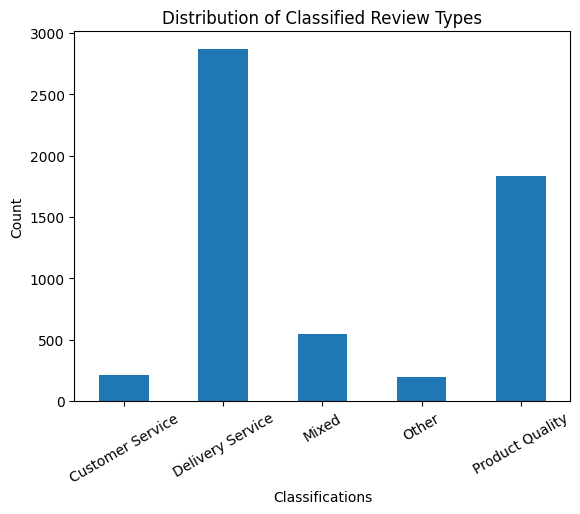

In [3]:
tagged_data.groupby(by="Tags").size().plot(kind="bar")#.count().plot(x= 'ID_SERVICE_REVIEW', kind="bar", 
plt.xticks(rotation=30)
plt.title("Distribution of Classified Review Types")
plt.xlabel("Classifications")
plt.ylabel("Count")

Because of this imbalance and the small size of the dataset overall, it is necessary to perform some adjustment. We choose to use SMOTE (Synthetic Minority Oversampling Technique) to create synthetic data based on the less common categories, which fills out our training data. This occurs in vectorized space, and the actual verbal representations of this synthetic data is unnecessary. 

## Classification (Logistic Regression + SMOTE)

A ```MultinomialNB()```  model was also considered, but appears to underperform the Logistic Regression model. You may choose to create new messages in the cell below, and observe how the model predicts their category at the end. 

In [4]:
#manual additions to test

#try inserting something like ["I hate these glasses", "They never arrived", "This is a spam response" into
#the made_up_responses list variable. Keep in mind how you expect them to be classified, 
#and determine whether it did so effectively


made_up_responses = []

null_classes = [np.nan]*len(made_up_responses)
made_up_df = pd.DataFrame(data={"DS_TEXT_TRANSLATED": made_up_responses, "Tags": null_classes, })

In [5]:
%%time

warnings.filterwarnings('ignore')

#initializing data source
before_vect = merged_data_big[["DS_TEXT_TRANSLATED", "Tags"]]

#adding extra text
before_vect = pd.concat([before_vect, made_up_df]).reset_index(drop=True)

#creating column transformer
columnTransformer = ColumnTransformer([('E',OneHotEncoder(dtype='int'),["DS_TEXT_TRANSLATED", "Tags"]),
 ('tfidf',TfidfVectorizer(stop_words=None, max_features=100000), 'DS_TEXT_TRANSLATED')], remainder='drop')

#transforming the dataset into its vectorized form
vector_transformer = columnTransformer.fit(before_vect)
vectorized_df = vector_transformer.transform(before_vect)

y = before_vect["Tags"]
y=y.to_frame()

#gathering the training and testing set. Note that there is no y_test variable, 
#because we do not have classifications for the majority of this dataset. 
#a version of this operating only on the classified data performed very well on testing

X_train = vectorized_df[before_vect["Tags"].isna()==False]

X_test = vectorized_df[before_vect["Tags"].isna()==True]

Y_train = y[before_vect["Tags"].isna()==False]


#creating the synthetic elements. Note we create these only from the training
#data, because creating synthetic data from both train and test would
#create a data leak, corrupting the integrity of our train/test division
smote = SMOTE(random_state=777,k_neighbors=5)
X_smote,y_smote = smote.fit_resample(X_train, Y_train)

#model creation
model = LogisticRegression()

#we fit the model on the mix of real and synthetic training data
model.fit(X_smote, y_smote)

#we predict the classifications
y_pred = model.predict(X_test)

tests = before_vect[before_vect["Tags"].isna()==True]["DS_TEXT_TRANSLATED"]

tests_df = pd.DataFrame(data={"text":tests, "classification": y_pred})

tests_df

CPU times: user 587 ms, sys: 21.6 ms, total: 608 ms
Wall time: 609 ms


,text,classification
0,I love the quality of the glasses!,Other
2,"Great, super pretty glasses. and good material",Product Quality
5,"I have received the box open and crushed, and ...",Customer Service
6,Awful!! Let no one understand here...\n\nI pla...,Customer Service
7,It arrived very late and now I'm trying to ret...,Customer Service
...,...,...
14954,"... top quality.\n\nawesome products, profesio...",Product Quality
14955,"Fast delivery, top quality",Mixed
14957,The price is good but some glasses arrived wit...,Product Quality
14958,2 time I order and incredible,Delivery Service


## Weaknesses and Concerns

The chief weakness of this model as demonstrated here is that it cannot be used to predict the classification of incoming reviews. Instead, it is necessary to vectorize all test inputs along with the training data, otherwise the model will expect the wrong number of features. 

However, this is not a major issue for us: the model trains and predicts very quickly, and assuming the pace of trustpilot reviews remains as it is (estimated ~200/week), simply running it each time one comes in would not be a significant drain on computing resources. This would be a problem if we wanted to scale this up, such as with a much larger training set or a high frequency of reviews, but that is not a problem at present. 

We also note that the proportions of predicted types below are very different from the classifications in the traiing set. It is not clear if this is because of real differences between the classified training set or distortions in the model. 

Text(0, 0.5, 'Count')

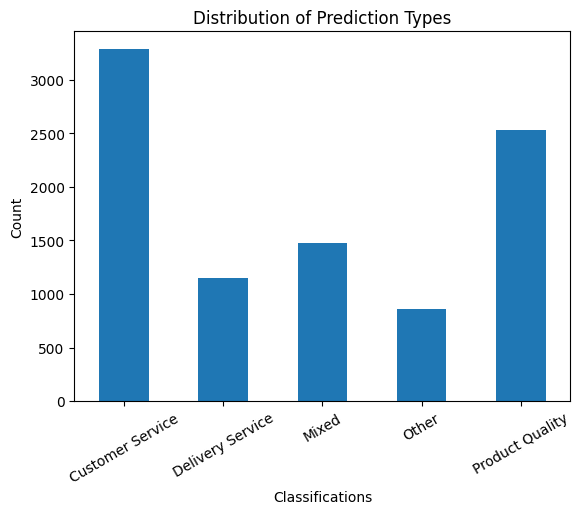

In [6]:
tests_df.groupby(by="classification").size().plot(kind="bar")#.count().plot(x= 'ID_SERVICE_REVIEW', kind="bar", 
plt.xticks(rotation=30)
plt.title("Distribution of Prediction Types")
plt.xlabel("Classifications")
plt.ylabel("Count")